# XGBoost para classificação da direção de criptos

In [98]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score, classification_mean_width_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
# Leitura dos dados
SYMBOL = 'SOLUSDT'
PERIOD = '1h'
df = pd.read_csv(f'../../data/fechamentos/{SYMBOL}_{PERIOD}_data.csv')
df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)

# Drop de colunas desnecessárias, quando o modelo é puxado pelo novo código
try:
    df.drop(columns=['close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'], inplace=True)
except:
    pass

In [100]:
# Construção das features
def create_features(df_input): # Renomeei para df_input para evitar conflito
    df_temp = df_input.copy()
    epsilon = 1e-10

    # Retorno e Volatilidade
    df_temp['return'] = df_temp['close'].pct_change()
    df_temp['return_skew_30'] = df_temp['return'].rolling(window=30).skew()
    df_temp['return_kurt_30'] = df_temp['return'].rolling(window=30).kurt()
    df_temp['volatility_10'] = df_temp['return'].rolling(window=10).std()
    df_temp['volatility_30'] = df_temp['return'].rolling(window=30).std()
    df_temp['volatility_200'] = df_temp['return'].rolling(window=200).std()
    df_temp['realized_vol_10'] = ((np.log(df_temp['high']) - np.log(df_temp['low']))**2 / 2 - \
                                (2 * np.log(2) - 1) * (np.log(df_temp['close']) - np.log(df_temp['open']))**2)\
                                .rolling(window=10).mean().apply(np.sqrt)
    df_temp['realized_vol_30'] = ((np.log(df_temp['high']) - np.log(df_temp['low']))**2 / 2 - \
                                (2 * np.log(2) - 1) * (np.log(df_temp['close']) - np.log(df_temp['open']))**2)\
                                .rolling(window=30).mean().apply(np.sqrt)
    df_temp['realized_vol_200'] = ((np.log(df_temp['high']) - np.log(df_temp['low']))**2 / 2 - \
                                (2 * np.log(2) - 1) * (np.log(df_temp['close']) - np.log(df_temp['open']))**2)\
                                .rolling(window=200).mean().apply(np.sqrt)
    
    # Volume
    def chaikin_money_flow(df, period=20):
        mfv = ((df['close'] - df['low']) - (df['high'] - df['close'])) / (df['high'] - df['low'] + epsilon) * df['volume']
        cmf = mfv.rolling(window=period).sum() / df['volume'].rolling(window=period).sum()
        return cmf
    df_temp['cmf_10'] = chaikin_money_flow(df_temp, period=10)
    df_temp['cmf_30'] = chaikin_money_flow(df_temp, period=30)
    df_temp['cmf_200'] = chaikin_money_flow(df_temp, period=200)

    df_temp['volume_10_normalizado'] = df_temp['volume'] / (df_temp['volume'].rolling(window=10).mean() + epsilon)
    df_temp['volume_30_normalizado'] = df_temp['volume'] / (df_temp['volume'].rolling(window=30).mean() + epsilon)
    df_temp['volume_200_normalizado'] = df_temp['volume'] / (df_temp['volume'].rolling(window=200).mean() + epsilon)

    # Osciladores
    def williams_r(high, low, close, period=14):
        highest_high = high.rolling(window=period).max()
        lowest_low = low.rolling(window=period).min()
        return ((highest_high - close) / (highest_high - lowest_low + epsilon)) * -100
    df_temp['williams_r_10'] = williams_r(df_temp['high'], df_temp['low'], df_temp['close'], period=10)
    df_temp['williams_r_10_slope'] = df_temp['williams_r_10'].diff().rolling(window=5).mean()
    df_temp['williams_r_30'] = williams_r(df_temp['high'], df_temp['low'], df_temp['close'], period=30)
    df_temp['williams_r_30_slope'] = df_temp['williams_r_30'].diff().rolling(window=5).mean()
    df_temp['williams_r_200'] = williams_r(df_temp['high'], df_temp['low'], df_temp['close'], period=200)
    df_temp['williams_r_200_slope'] = df_temp['williams_r_200'].diff().rolling(window=5).mean()

    # MACD
    ema_12 = df_temp['close'].ewm(span=12, adjust=False).mean()
    ema_26 = df_temp['close'].ewm(span=26, adjust=False).mean()
    df_temp['macd'] = ema_12 - ema_26
    df_temp['macd_normalizado'] = df_temp['macd'] / df_temp['close']
    df_temp['macd_signal'] = df_temp['macd'].ewm(span=9, adjust=False).mean()
    df_temp['macd_hist'] = df_temp['macd'] - df_temp['macd_signal']
    df_temp['macd_slope'] = df_temp['macd'].diff().rolling(window=5).mean()

    # Bandas de Bollinger
    rolling_mean_20 = df_temp['close'].rolling(window=20).mean()
    rolling_std_20 = df_temp['close'].rolling(window=20).std()
    df_temp['bb_upper'] = rolling_mean_20 + (rolling_std_20 * 2)
    df_temp['bb_lower'] = rolling_mean_20 - (rolling_std_20 * 2)
    df_temp['bb_width'] = df_temp['bb_upper'] - df_temp['bb_lower']
    df_temp['bb_pos'] = (df_temp['close'] - df_temp['bb_lower']) / (df_temp['bb_width'] + epsilon)
    df_temp['bb_width_normalizada'] = (df_temp['bb_upper'] - df_temp['bb_lower']) / df_temp['close']

    # Volume
    price_direction = np.sign(df_temp['close'].diff()).fillna(0)
    df_temp['obv'] = (price_direction * df_temp['volume']).cumsum()
    df_temp['obv_slope'] = df_temp['obv'].diff().rolling(window=5).mean()
    df_temp['vol_osc'] = df_temp['volume'].rolling(5).mean() / (df_temp['volume'].rolling(20).mean() + epsilon)
    def calculate_ad(df):
        mfm = ((df['close'] - df['low']) - (df['high'] - df['close'])) / (df['high'] - df['low'])
        mfm = mfm.fillna(0)
        mfv = mfm * df['volume']
        ad_line = mfv.cumsum()
        return ad_line
    df_temp['ad'] = calculate_ad(df_temp[['close', 'high', 'low', 'volume']])

    # Volatilidade (ATR)
    def atr(df_atr, window=14):
        tr_high_low = df_atr['high'] - df_atr['low']
        tr_high_prev_close = abs(df_atr['high'] - df_atr['close'].shift())
        tr_low_prev_close = abs(df_atr['low'] - df_atr['close'].shift())
        tr = pd.DataFrame({'hl': tr_high_low, 'hpc': tr_high_prev_close, 'lpc': tr_low_prev_close}).max(axis=1)
        return tr.rolling(window=window).mean()
    df_temp['atr_10'] = atr(df_temp, window=10)
    df_temp['atr_10_normalizado'] = df_temp['atr_10'] / df_temp['close']
    df_temp['atr_10_slope'] = df_temp['atr_10'].diff().rolling(window=5).mean()
    df_temp['atr_30'] = atr(df_temp, window=20)
    df_temp['atr_30_normalizado'] = df_temp['atr_30'] / df_temp['close']
    df_temp['atr_30_slope'] = df_temp['atr_30'].diff().rolling(window=5).mean()
    df_temp['atr_200'] = atr(df_temp, window=200)
    df_temp['atr_200_normalizado'] = df_temp['atr_200'] / df_temp['close']
    df_temp['atr_200_slope'] = df_temp['atr_200'].diff().rolling(window=5).mean()

    # ADX (Força da Tendência)
    def adx(df_adx, period=14):
        high = df_adx['high']
        low = df_adx['low']
        close = df_adx['close']

        up = high.diff()
        down = -low.diff()

        plus_dm = np.where((up > down) & (up > 0), up, 0)
        minus_dm = np.where((down > up) & (down > 0), down, 0)

        tr1 = high - low
        tr2 = abs(high - close.shift(1))
        tr3 = abs(low - close.shift(1))
        tr = pd.DataFrame({'tr1': tr1, 'tr2': tr2, 'tr3': tr3}).max(axis=1)

        atr_val = tr.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
        plus_di = 100 * (pd.Series(plus_dm, index=df_adx.index).ewm(alpha=1/period, min_periods=period, adjust=False).mean() / (atr_val + epsilon))
        minus_di = 100 * (pd.Series(minus_dm, index=df_adx.index).ewm(alpha=1/period, min_periods=period, adjust=False).mean() / (atr_val + epsilon))

        dx = 100 * (abs(plus_di - minus_di) / (plus_di + minus_di + epsilon))
        adx_val = dx.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
        return adx_val, plus_di, minus_di
    df_temp['adx_10'], df_temp['pdi_10'], df_temp['ndi_10'] = adx(df_temp, period=10)
    df_temp['adx_30'], df_temp['pdi_30'], df_temp['ndi_30'] = adx(df_temp, period=30)
    df_temp['adx_10_slope'] = df_temp['adx_10'].diff().rolling(window=5).mean()
    df_temp['pdi_10_slope'] = df_temp['pdi_10'].diff().rolling(window=5).mean()
    df_temp['ndi_10_slope'] = df_temp['ndi_10'].diff().rolling(window=5).mean()
    df_temp['adx_30_slope'] = df_temp['adx_30'].diff().rolling(window=5).mean()
    df_temp['pdi_30_slope'] = df_temp['pdi_30'].diff().rolling(window=5).mean()
    df_temp['ndi_30_slope'] = df_temp['ndi_30'].diff().rolling(window=5).mean()

    # RSI (Índice de Força Relativa)
    def rsi(close, period=14):
        delta = close.diff()
        gain = delta.clip(lower=0).ewm(alpha=1/period, min_periods=period, adjust=False).mean()
        loss = -delta.clip(upper=0).ewm(alpha=1/period, min_periods=period, adjust=False).mean()
        rs = gain / (loss + epsilon)
        return 100 - (100 / (1 + rs))
    df_temp['rsi_10'] = rsi(df_temp['close'], period=10)
    df_temp['rsi_10_slope'] = df_temp['rsi_10'].diff().rolling(window=5).mean()
    df_temp['rsi_30'] = rsi(df_temp['close'], period=30)
    df_temp['rsi_30_slope'] = df_temp['rsi_30'].diff().rolling(window=5).mean()

    # Momentum
    def mom(close, period=10):
        return close.diff(period)
    df_temp['mom_10'] = mom(df_temp['close'], period=10)
    df_temp['mom_10_slope'] = df_temp['mom_10'].diff().rolling(window=5).mean()
    df_temp['mom_10_normalizado'] = df_temp['mom_10'] / df_temp['close']
    df_temp['mom_30'] = mom(df_temp['close'], period=30)
    df_temp['mom_30_slope'] = df_temp['mom_30'].diff().rolling(window=5).mean()
    df_temp['mom_30_normalizado'] = df_temp['mom_30'] / df_temp['close']
    df_temp['mom_200'] = mom(df_temp['close'], period=200)
    df_temp['mom_200_slope'] = df_temp['mom_200'].diff().rolling(window=5).mean()
    df_temp['mom_200_normalizado'] = df_temp['mom_200'] / df_temp['close']

    # Estocástico
    def stochastic_oscillator(high, low, close, period=14):
        lowest_low = low.rolling(window=period).min()
        highest_high = high.rolling(window=period).max()
        k = 100 * ((close - lowest_low) / (highest_high - lowest_low + epsilon))
        d = k.rolling(window=3).mean()
        return k, d
    df_temp['stoch_10'], df_temp['stoch_d_10'] = stochastic_oscillator(df_temp['high'], df_temp['low'], df_temp['close'], period=10)
    df_temp['stoch_10_slope'] = df_temp['stoch_10'].diff().rolling(window=5).mean()
    df_temp['stoch_d_10_slope'] = df_temp['stoch_d_10'].diff().rolling(window=5).mean()
    df_temp['stoch_30'], df_temp['stoch_d_30'] = stochastic_oscillator(df_temp['high'], df_temp['low'], df_temp['close'], period=30)
    df_temp['stoch_30_slope'] = df_temp['stoch_30'].diff().rolling(window=5).mean()
    df_temp['stoch_d_30_slope'] = df_temp['stoch_d_30'].diff().rolling(window=5).mean()
    df_temp['stoch_200'], df_temp['stoch_d_200'] = stochastic_oscillator(df_temp['high'], df_temp['low'], df_temp['close'], period=200)
    df_temp['stoch_200_slope'] = df_temp['stoch_200'].diff().rolling(window=5).mean()
    df_temp['stoch_d_200_slope'] = df_temp['stoch_d_200'].diff().rolling(window=5).mean()

    # Parabolic SAR
    def parabolic_sar(high, low, close, acceleration=0.02, maximum=0.2):
        length = len(close)
        if length < 2:
            return pd.Series([None] * length, index=close.index)
        sar = [None] * length
        is_long = close.iloc[1] > close.iloc[0]
        sar[1] = low.iloc[0] if is_long else high.iloc[0]
        ep = high.iloc[1] if is_long else low.iloc[1]
        af = acceleration

        for i in range(2, length):
            prev_sar = sar[i-1]
            if is_long:
                new_sar = prev_sar + af * (ep - prev_sar)
                if new_sar > low.iloc[i] or new_sar > low.iloc[i-1]:
                    is_long = False
                    af = acceleration
                    new_sar = ep
                    ep = low.iloc[i]
                else:
                    if high.iloc[i] > ep:
                        ep = high.iloc[i]
                        af = min(af + acceleration, maximum)
            else:
                new_sar = prev_sar + af * (ep - prev_sar)
                if new_sar < high.iloc[i] or new_sar < high.iloc[i-1]:
                    is_long = True
                    af = acceleration
                    new_sar = ep
                    ep = high.iloc[i]
                else:
                    if low.iloc[i] < ep:
                        ep = low.iloc[i]
                        af = min(af + acceleration, maximum)
            sar[i] = new_sar
            
        return pd.Series(sar, index=close.index)
    df_temp['sar'] = parabolic_sar(df_temp['high'], df_temp['low'], df_temp['close'])

    # EMA (Média Móvel Exponencial)
    df_temp['ema_10'] = df_temp['close'].ewm(span=10, adjust=False).mean()
    df_temp['ema_50'] = df_temp['close'].ewm(span=50, adjust=False).mean()
    df_temp['ema_200'] = df_temp['close'].ewm(span=200, adjust=False).mean()
    df_temp['ema_10_slope'] = df_temp['ema_10'].diff().rolling(window=5).mean()
    df_temp['ema_50_slope'] = df_temp['ema_50'].diff().rolling(window=5).mean()
    df_temp['ema_200_slope'] = df_temp['ema_200'].diff().rolling(window=5).mean()
    df_temp['ema_10_normalizada'] = df_temp['ema_10'] / df_temp['close']
    df_temp['ema_50_normalizada'] = df_temp['ema_50'] / df_temp['close']
    df_temp['ema_200_normalizada'] = df_temp['ema_200'] / df_temp['close']

    # Retorno Cumulativo
    df_temp['cum_return_10'] = df_temp['close'].rolling(10).apply(lambda x: (x.iloc[-1] / x.iloc[0]) - 1)
    df_temp['cum_return_30'] = df_temp['close'].rolling(30).apply(lambda x: (x.iloc[-1] / x.iloc[0]) - 1)
    df_temp['cum_return_200'] = df_temp['close'].rolling(200).apply(lambda x: (x.iloc[-1] / x.iloc[0]) - 1)

    # Lag Features
    lag_cols = df_temp.columns.tolist()
    for col in lag_cols:
        for lag in range(1, 4):
            df_temp[f'{col}_lag_{lag}'] = df_temp[col].shift(lag)

    df_temp.dropna(inplace=True)
    return df_temp

# Aplica a função de criação de features
df = create_features(df)

# --- DEFINIÇÃO DO TARGET ---
retorno_futuro = df['close'].shift(-1) / df['close'] - 1
limiar_lucro = 0.0005

df['target'] = np.where(retorno_futuro > limiar_lucro, 1, 0) # 1 para retorno acima do limiar, 0 para abaixo

print(df['target'].value_counts(normalize=True))
print(df['target'].value_counts())

# Divisão dos dados entre até 2025 e a partir de 2025
df_in_sample = df[df.index < '2025-01-01']
df_out_of_sample = df[df.index >= '2025-01-01']

C:\Users\david\AppData\Local\Temp\ipykernel_5676\245377332.py:231: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[f'{col}_lag_{lag}'] = df_temp[col].shift(lag)
C:\Users\david\AppData\Local\Temp\ipykernel_5676\245377332.py:231: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[f'{col}_lag_{lag}'] = df_temp[col].shift(lag)
C:\Users\david\AppData\Local\Temp\ipykernel_5676\245377332.py:231: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

target
0    0.523501
1    0.476499
Name: proportion, dtype: float64
target
0    22543
1    20519
Name: count, dtype: int64


C:\Users\david\AppData\Local\Temp\ipykernel_5676\245377332.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = np.where(retorno_futuro > limiar_lucro, 1, 0) # 1 para retorno acima do limiar, 0 para abaixo


--- INICIANDO VALIDAÇÃO E SIMULAÇÃO ENCADEADA COM 10 FOLDS ---

--- Processando Fold 1/10 ---
Quantidade dos dados: 2784 para treino e 697 para calibração
Benchmark 'Buy & Hold' total iniciará em 2021-01-12 com preço 3.39
MAPIE - Cobertura no fold: 90.91% | Tamanho médio do conjunto: 1.81
Saldo inicial do Fold: 1000.00 | Saldo Final do Fold: 2508.70 | Trades: 42

--- Processando Fold 2/10 ---
Quantidade dos dados: 5567 para treino e 1392 para calibração
MAPIE - Cobertura no fold: 91.00% | Tamanho médio do conjunto: 1.82
Saldo inicial do Fold: 2508.70 | Saldo Final do Fold: 6065.75 | Trades: 46

--- Processando Fold 3/10 ---
Quantidade dos dados: 8349 para treino e 2088 para calibração
MAPIE - Cobertura no fold: 92.09% | Tamanho médio do conjunto: 1.81
Saldo inicial do Fold: 6065.75 | Saldo Final do Fold: 5441.93 | Trades: 16

--- Processando Fold 4/10 ---
Quantidade dos dados: 11132 para treino e 2783 para calibração
MAPIE - Cobertura no fold: 92.32% | Tamanho médio do conjunto: 1.84
S

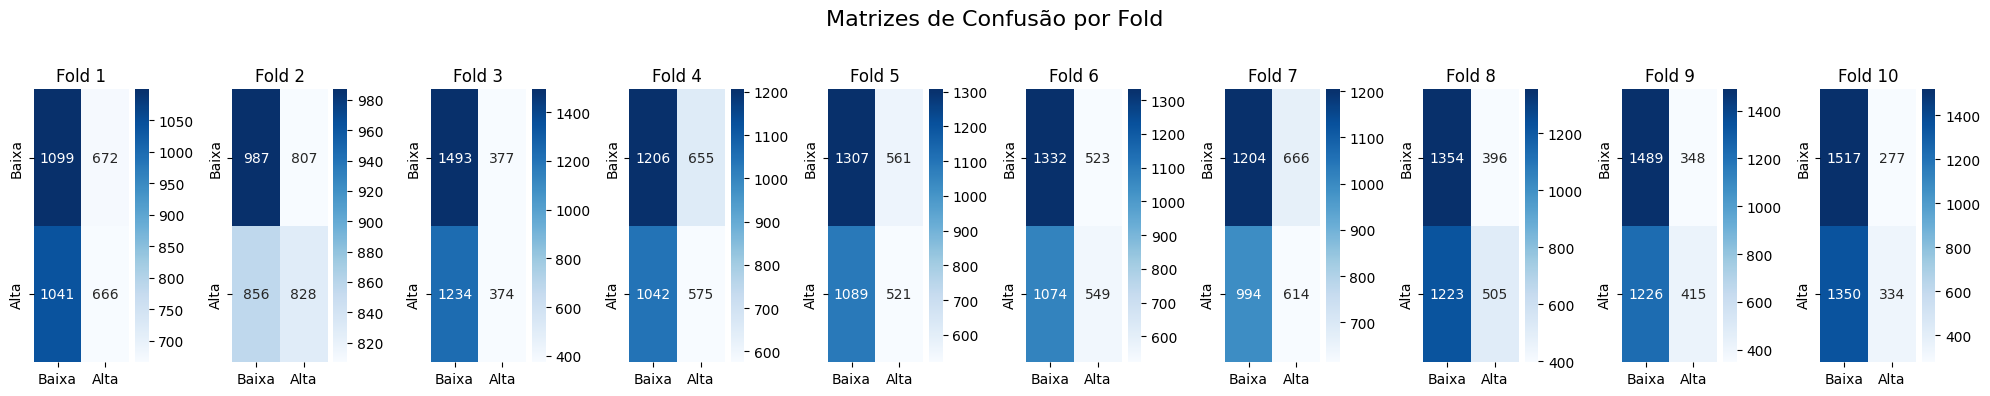


-----------------------------------
| Resumo das Métricas por Fold      |
-----------------------------------


,AUC,Acurácia,Precisão,Recall,F1 Score
Fold,,,,,
1,0.518998,0.507476,0.497758,0.390158,0.437438
2,0.516388,0.521852,0.506422,0.491686,0.498945
3,0.525313,0.536803,0.498003,0.232587,0.317084
4,0.508302,0.512076,0.467480,0.355597,0.403934
5,0.521499,0.525589,0.481516,0.323602,0.387073
6,0.539477,0.540828,0.512127,0.338262,0.407421
7,0.525472,0.522714,0.479687,0.381841,0.425208
8,0.548473,0.534503,0.560488,0.292245,0.384176
9,0.548212,0.547441,0.543906,0.252895,0.345258


Média do AUC: 0.5299
Média do Recall: 0.3257


------------------------------------------------------------
| Resumo da Performance da Simulação por Fold de Teste      |
------------------------------------------------------------
 Fold Período Início Período Fim  Saldo Inicial  Saldo Final  Retorno Estratégia (%)  Retorno Buy & Hold (%)  Retorno Líquido (%)  Nº Trades
    1     2021-01-12  2021-06-06    1000.000000  2508.701088              150.870109             1108.930573          -958.060464         42
    2     2021-06-06  2021-10-29    2508.701088  6065.753163              141.788597              387.757970          -245.969373         46
    3     2021-10-29  2022-03-23    6065.753163  5441.929264              -10.284360              -54.157170            43.872810         16
    4     2022-03-23  2022-08-15    5441.929264  6016.852152               10.564689              -51.918075            62.482764         28
    5     2022-08-15  2023-01-07    6016.852152  4396.033851    

In [ ]:
def simulate_trading(test_df_fold: pd.DataFrame, 
                                initial_balance_fold: float, 
                                fee: float = 0.001, 
                                stop_loss: float = None, 
                                take_profit: float = None,
                                trailing_stop: float = 0.02,
                                sma_window: int = 100) -> tuple[list, float]:
    """
    Simula uma estratégia de trading usando os conjuntos de previsão do MAPIE.
    """
    df_sim = test_df_fold.copy()

    balance = initial_balance_fold
    position = 0.0
    entry_price = 0.0
    trades = []

    # Variável para o trailing stop dinâmico
    trailing_stop_price = None

    # Calculo da média simples
    df_sim['sma_long'] = df_sim['close'].rolling(window=sma_window).mean()

    # Simulação de passos no tempo
    for i in range(1, len(df_sim)):
        current_price = df_sim['close'].iloc[i]
        current_time = df_sim.index[i]

        # O sinal de trading é baseado na previsão do candle ANTERIOR (t-1)
        prediction_set_t_minus_1 = df_sim['prediction_set'].iloc[i-1]

        # Verifica se já existe posição antes
        if position > 0:
            # 1. Stop-Loss
            if stop_loss is not None and current_price <= entry_price * (1 - stop_loss):
                balance = position * current_price * (1 - fee)
                trades.append(('Stop-Loss', current_time, current_price, balance, f'SL {stop_loss*100:.1f}% hit'))
                position, entry_price, trailing_stop_price = 0.0, 0.0, None
                continue

            # 2. Take-Profit
            if take_profit is not None and current_price >= entry_price * (1 + take_profit):
                balance = position * current_price * (1 - fee)
                trades.append(('Take-Profit', current_time, current_price, balance, f'TP {take_profit*100:.1f}% hit'))
                position, entry_price, trailing_stop_price = 0.0, 0.0, None
                continue

            # 3. Trailing Stop
            if trailing_stop is not None:
                # Define o stop inicial ou atualiza se o preço subir
                new_stop_price = current_price * (1 - trailing_stop)
                if trailing_stop_price is None:
                    trailing_stop_price = entry_price * (1 - trailing_stop)
                else:
                    trailing_stop_price = max(trailing_stop_price, new_stop_price)

                # Verifica se o trailing stop foi atingido
                if current_price <= trailing_stop_price:
                    balance = position * current_price * (1 - fee)
                    trades.append(('Trailing-Stop', current_time, current_price, balance, f'Trailing stop {trailing_stop*100:.1f}% hit'))
                    position, entry_price, trailing_stop_price = 0.0, 0.0, None
                    continue

        is_uptrend = current_price > df_sim['sma_long'].iloc[i]

        # Compra quando o modelo está confiante na ALTA ([False, True]) e não estamos posicionados
        if np.array_equal(prediction_set_t_minus_1, [False, True]) and position == 0 and is_uptrend:
            amount_to_spend = balance * (1 - fee)
            qty = amount_to_spend / current_price
            position = qty
            entry_price = current_price
            balance = 0.0 # Saldo em caixa vai a zero
            trades.append(('Buy', current_time, current_price, balance, 'Sinal MAPIE: Compra Confiante {1}'))

        # Vende quando o modelo está confiante na BAIXA ([True, False]) e estamos posicionados
        elif np.array_equal(prediction_set_t_minus_1, [True, False]) and position > 0:
            balance = position * current_price * (1 - fee)
            trades.append(('Sell', current_time, current_price, balance, 'Sinal MAPIE: Venda Confiante {0}'))
            position, entry_price, trailing_stop_price = 0.0, 0.0, None

    # Fecha as posições no fim da simulação
    if position > 0:
        last_price = df_sim['close'].iloc[-1]
        balance = position * last_price * (1 - fee)
        trades.append(('Liquidate_Final_Fold', df_sim.index[-1], last_price, balance, 'Fim do período de teste'))
        position = 0.0

    return trades, balance

# Configurações da Simulação
initial_balance = 1000.0
classification_threshold = 0.5

# Variáveis para armazenar resultados
results_list = []
full_simulation_trades = []
current_global_balance = initial_balance
fold_performance_list = []
overall_benchmark_start_price = None

# Validação cruzada com TimeSeriesSplit
n_splits = 10
tsv = TimeSeriesSplit(n_splits=n_splits)
X = df_in_sample.drop(columns=['target'])
y = df_in_sample['target']

fig, axes = plt.subplots(1, n_splits, figsize=(20, 4))
fig.suptitle('Matrizes de Confusão por Fold', fontsize=16)

print(f"--- INICIANDO VALIDAÇÃO E SIMULAÇÃO ENCADEADA COM {n_splits} FOLDS ---")

for fold, (train_index, test_index) in enumerate(tsv.split(X)):
    print(f"\n--- Processando Fold {fold + 1}/{n_splits} ---")
    X_train_full, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train_full, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train, X_calib, y_train, y_calib = train_test_split(
        X_train_full, y_train_full, test_size=0.2, shuffle=False
    )

    print(f"Quantidade dos dados: {X_train.shape[0]} para treino e {X_calib.shape[0]} para calibração")

    # Captura o preço de início do benchmark na primeira iteração
    if fold == 0:
        first_test_period_start_index = X_test.index[0]
        overall_benchmark_start_price = df_in_sample.loc[first_test_period_start_index, 'close']
        print(f"Benchmark 'Buy & Hold' total iniciará em {first_test_period_start_index.date()} com preço {overall_benchmark_start_price:.2f}")

    # Construção do modelo
    model = xgb.XGBClassifier(
        n_estimators=1000, objective='binary:logistic', learning_rate=0.01,
        max_depth=7, scale_pos_weight=max(y_train.value_counts()[0], y_train.value_counts()[1]) / min(y_train.value_counts()[1], y_train.value_counts()[0]),
        subsample=0.8, colsample_bytree=0.8, gamma=0.1,
        early_stopping_rounds=50, random_state=1, n_jobs=-1
    )

    # Treinamento do modelo
    model.fit(X_train, y_train, eval_set=[(X_calib, y_calib)], verbose=0)

    # Predição dos dados
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > classification_threshold).astype(int)

    # Armazenamento dos resultados do fold
    fold_results = {
        'Fold': fold + 1, 'AUC': roc_auc_score(y_test, y_proba),
        'Acurácia': accuracy_score(y_test, y_pred), 'Precisão': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0), 'F1 Score': f1_score(y_test, y_pred, zero_division=0)
    }
    results_list.append(fold_results)

    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[fold], xticklabels=['Baixa', 'Alta'], yticklabels=['Baixa', 'Alta'])
    axes[fold].set_title(f'Fold {fold + 1}')

    # Ajuste do modelo MAPIE
    mapie_model = MapieClassifier(estimator=model, method="lac", cv="prefit")
    mapie_model.fit(X_calib, y_calib)

    alpha = 0.1  # Nível de significância
    y_pred, y_set = mapie_model.predict(X_test, alpha=alpha)
    y_set = np.squeeze(y_set)

    # Calcula e exibe métricas de incerteza para o fold
    coverage = classification_coverage_score(y_test, y_set)
    set_size = classification_mean_width_score(y_set)
    print(f"MAPIE - Cobertura no fold: {coverage:.2%} | Tamanho médio do conjunto: {set_size:.2f}")

    # Preparação dos dados para simulação
    test_df_for_sim = df_in_sample.loc[X_test.index].copy()
    test_df_for_sim['target'] = y_test

    test_df_for_sim['prediction_set'] = list(y_set)
    
    fold_initial_balance = current_global_balance

    # Simulação Out-of-Sample para confirmação da ausência de overfitting
    trades_fold, final_balance_fold = simulate_trading(
        test_df_for_sim, 
        initial_balance_fold=fold_initial_balance,
        trailing_stop=0.1
    )
    
    print(f"Saldo inicial do Fold: {fold_initial_balance:.2f} | Saldo Final do Fold: {final_balance_fold:.2f} | Trades: {len(trades_fold)}")

    # Cálculo dos Retornos
    strategy_return_fold = ((final_balance_fold - fold_initial_balance) / fold_initial_balance) * 100 if fold_initial_balance > 0 else 0
    buy_and_hold_start_price = test_df_for_sim['close'].iloc[0]
    buy_and_hold_end_price = test_df_for_sim['close'].iloc[-1]
    buy_and_hold_return_fold = ((buy_and_hold_end_price - buy_and_hold_start_price) / buy_and_hold_start_price) * 100

    # Armazenamento dos resultados do fold
    fold_performance_list.append({
        "Fold": fold + 1, "Período Início": X_test.index[0].date(),
        "Período Fim": X_test.index[-1].date(), "Saldo Inicial": fold_initial_balance,
        "Saldo Final": final_balance_fold, "Retorno Estratégia (%)": strategy_return_fold,
        "Retorno Buy & Hold (%)": buy_and_hold_return_fold, "Retorno Líquido (%)": strategy_return_fold - buy_and_hold_return_fold,
        "Nº Trades": len(trades_fold)
    })
    
    current_global_balance = final_balance_fold
    full_simulation_trades.extend(trades_fold)
    
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- APRESENTAÇÃO DOS RESULTADOS ---

# 1. Métricas de Classificação por Fold
results_df = pd.DataFrame(results_list)
print("\n" + "-"*35)
print("| Resumo das Métricas por Fold      |")
print("-"*(35))
display(results_df.set_index('Fold'))
print(f"Média do AUC: {results_df['AUC'].mean():.4f}")
print(f"Média do Recall: {results_df['Recall'].mean():.4f}")

# 2. Performance da Estratégia por Fold
print("\n\n" + "-"*60)
print("| Resumo da Performance da Simulação por Fold de Teste      |")
print("-"*(60))
performance_by_fold_df = pd.DataFrame(fold_performance_list)
print(performance_by_fold_df.to_string(index=False))
performance_by_fold_df.to_csv(f'folds_performance_{SYMBOL}_{PERIOD}.csv', index=False)

# 3. Resumo Final da Simulação Encadeada
print("\n\n--- Resumo Final da Simulação (Total) ---")

total_return = ((current_global_balance - initial_balance) / initial_balance) * 100
overall_benchmark_end_price = df_in_sample['close'].iloc[-1]
total_return_natural = ((overall_benchmark_end_price - overall_benchmark_start_price) / overall_benchmark_start_price) * 100

print(f"Saldo Inicial Total: {initial_balance:.2f} USDT")
print(f"Saldo Final Total: {current_global_balance:.2f} USDT")
print(f"Retorno Total no Período (Estratégia): {total_return:.2f}%")
print(f"Retorno Total no Período (Buy & Hold): {total_return_natural:.2f}%")
print(f"Retorno Total Líquido (Alpha): {total_return - total_return_natural:.2f}%")
print(f"Total de Transações: {len(full_simulation_trades)}")
print("--- Fim da Simulação ---")

In [102]:
# Simulação Out-of-Sample para confirmação da ausência de overfitting
test_df_for_sim = df_out_of_sample.copy()

# O próprio simulate_trading já recebe o modelo e formata os dados para calcular
trades_fold, final_balance_fold = simulate_trading(
    test_df_for_sim,
    initial_balance_fold=fold_initial_balance,
    trailing_stop=0.1
)

print(f"Saldo inicial do Fold: {fold_initial_balance:.2f} | Saldo Final do Fold: {final_balance_fold:.2f} | Trades: {len(trades_fold)}")
print(f"Lucro/Prejuízo do Fold: {final_balance_fold - fold_initial_balance:.2f} USDT")
print(f"Retorno do Fold: {((final_balance_fold - fold_initial_balance) / fold_initial_balance) * 100:.2f}%")
print(f"Retorno Buy & Hold: {((df_out_of_sample['close'].iloc[-1] - df_out_of_sample['close'].iloc[0]) / df_out_of_sample['close'].iloc[0]) * 100:.2f}%")

KeyError: 'prediction_set'

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

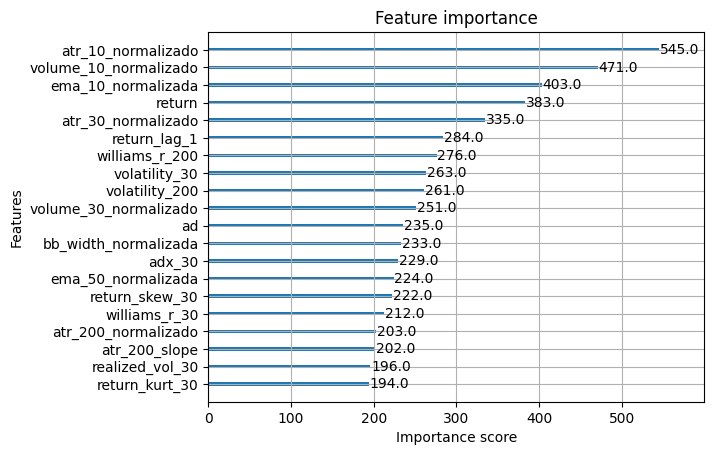

In [ ]:
xgb.plot_importance(model, max_num_features=20, importance_type='weight')

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

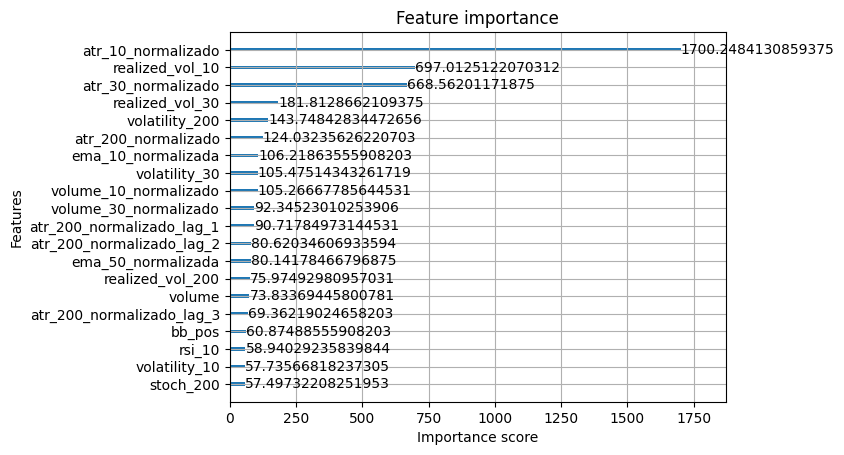

In [ ]:
xgb.plot_importance(model, max_num_features=20, importance_type='gain')

In [ ]:
for trade in full_simulation_trades:
    print(f"{trade[0]} em {trade[1]}: Preço {trade[2]:.2f}, Saldo {trade[3]:.2f} USDT, Detalhes: {trade[4]}")

Buy em 2018-04-25 10:45:00: Preço 9140.68, Saldo 0.00 USDT, Detalhes: Sinal MAPIE: Compra Confiante {1}
Sell_Uncertainty em 2018-04-25 11:00:00: Preço 9083.91, Saldo 991.80 USDT, Detalhes: Sinal MAPIE: Incerteza {0, 1}
Buy em 2018-04-25 14:45:00: Preço 8880.00, Saldo 0.00 USDT, Detalhes: Sinal MAPIE: Compra Confiante {1}
Sell_Uncertainty em 2018-04-25 15:00:00: Preço 8869.99, Saldo 988.70 USDT, Detalhes: Sinal MAPIE: Incerteza {0, 1}
Buy em 2018-04-25 23:30:00: Preço 8805.00, Saldo 0.00 USDT, Detalhes: Sinal MAPIE: Compra Confiante {1}
Sell_Uncertainty em 2018-04-25 23:45:00: Preço 8869.99, Saldo 994.01 USDT, Detalhes: Sinal MAPIE: Incerteza {0, 1}
Buy em 2018-04-27 20:45:00: Preço 8970.00, Saldo 0.00 USDT, Detalhes: Sinal MAPIE: Compra Confiante {1}
Sell_Uncertainty em 2018-04-27 21:00:00: Preço 9029.92, Saldo 998.65 USDT, Detalhes: Sinal MAPIE: Incerteza {0, 1}
Buy em 2018-04-29 10:45:00: Preço 9210.03, Saldo 0.00 USDT, Detalhes: Sinal MAPIE: Compra Confiante {1}
Sell_Uncertainty em 